<a href="https://colab.research.google.com/github/bkvkrll/PyTorch/blob/main/lesson5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание

Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

Обучить модель на выбор из segmentation_models_pytorch


In [ ]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 58 kB 8.4 MB/s 
     |████████████████████████████████| 376 kB 58.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d5a4c813b994f80d5e0ae9192ddd6e541d0f274c28142aa7803303ab13dbc274
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3b2ce896aeee0abbc90a601a9712ddcae9e82e064e6c6f81a2967fa3c63e619e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import os
import time

from pathlib import Path
from PIL import Image

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


import segmentation_models_pytorch as smp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_file = '/content/drive/MyDrive/set-lipstick-original/list.csv'
images_path = '/content/drive/MyDrive/set-lipstick-original/720p'
masks_path = '/content/drive/MyDrive/set-lipstick-original/mask'

In [ ]:
df = pd.read_csv(dataset_file)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [ ]:
files_names_list = sorted(os.listdir(images_path))
masks_names_list = sorted(os.listdir(masks_path))
print(f'Количество изображений {len(files_names_list)}')
print(f'Количество масок {len(masks_names_list)}')

Количество изображений 28594
Количество масок 13427


In [ ]:
df = df.loc[df['mask'].isin([i for i in masks_names_list])]
df = df.loc[df['filename'].isin([i for i in files_names_list])]
df.reset_index(drop=True, inplace=True)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


TypeError: ignored

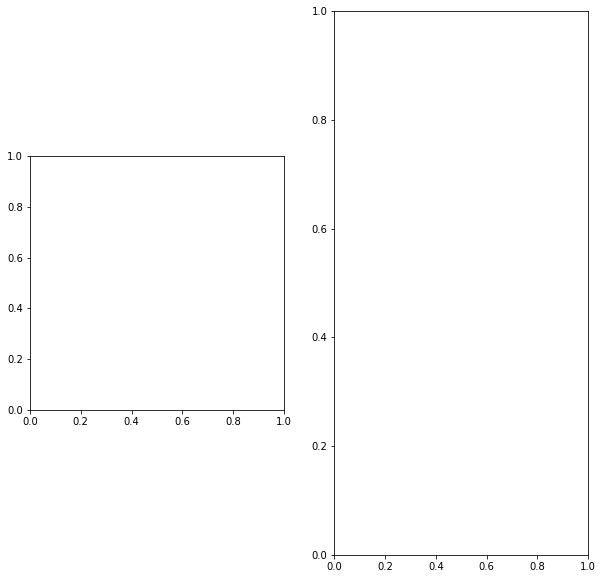

In [ ]:
image = cv2.imread(images_path + files_names_list[0], cv2.COLOR_BGR2RGB)
mask = cv2.imread(masks_path + masks_names_list[0], cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[0].set_title(f'Изображение {image.shape}')
ax[1].imshow(mask)
ax[1].set_title(f'Маска {mask.shape}')
plt.show()

In [ ]:
data = df[['filename', 'mask']]
data.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [ ]:
segmodel = smp.Linknet(encoder_name = 'resnet34', 
                    encoder_weights = 'imagenet', 
                    in_channels = 3, 
                    classes = 1, # число каналов маски
                    activation = 'sigmoid')

#предобученный декодер модели
preprocess_input = smp.encoders.get_preprocessing_fn('resnet34', pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # загружаем данные из датасета
        self.data = data
        self.preprocessing = preprocessing
        self.image_arr = self.data.iloc[:,0] # имена файлов картинок из датасета
        self.label_arr = self.data.iloc[:,1] # имена файлов масок из датасета
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
        
    def __getitem__(self, index):
       # загружаем картинки
        img = cv2.imread(images_path+self.image_arr[index]) 
        img = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2RGB)
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2,0,1)
        
        # загружаем маски
        mask = cv2.imread(masks_path+self.label_arr[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)        
        cls_mask = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks = [cls_mask]
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        
        return (img.float(), masks)

In [ ]:
#разделение датасета на train и test
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)

#сбрасываем индексы
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

#создаем датасеты
train_data = CustomDataset(X_train, preprocessing=preprocess_input)
test_data = CustomDataset(X_test, preprocessing=preprocess_input)

#создаем даталодеры
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [ ]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

Обучение и оценка модели Linknet из segmentation_models_pytorch

In [ ]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]
optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

#определение тренировочных и валидационных эпох
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    verbose=True)

In [ ]:
num_epochs = 10
linknet_train_iou = []
linknet_valid_iou = []

for i in range(num_epochs):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    linknet_train_iou.append(train_logs['iou_score'])
    linknet_valid_iou.append(valid_logs['iou_score'])

In [ ]:
x = np.arange(1,11,1)
y = linknet_train_iou
y2 = linknet_valid_iou

plt.plot(x,y,label='IOU_train')
plt.plot(x,y2,label='IOU_val')

plt.title(f"Linknet")   
plt.ylabel('IOU_score')   
plt.xlabel('epochs')   
plt.legend()
plt.show()

In [ ]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images
    labels = labels
    
    outputs = segmodel(images)
    
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
        axarr[0].set_title('Guessed labels')
        
        axarr[1].imshow(labels[i, ].cpu().permute(1, 2, 0))
        axarr[1].set_title('Ground truth labels')
        
        image = images[i].permute(1, 2, 0)
        axarr[2].imshow(image.cpu())
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 2:
        break

Обучение и оценка модели Unet из segmentation_models_pytorch

In [ ]:
unet = smp.Unet(encoder_name = 'resnet34', 
                encoder_weights = 'imagenet', 
                in_channels = 3, 
                classes = 1, # число каналов маски
                activation = 'sigmoid')

#предобученный декодер модели
preprocess_input = smp.encoders.get_preprocessing_fn('resnet34', pretrained='imagenet')

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)

#сбрасываем индексы
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

#создаем датасеты
train_data = CustomDataset(X_train, preprocessing=preprocess_input)
test_data = CustomDataset(X_test, preprocessing=preprocess_input)

#создаем даталодеры
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [ ]:
#определение критерия, метрики и оптимизатора
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]
optimizer = torch.optim.Adam(params=unet.parameters(), lr=0.001)

#определение тренировочных и валидационных эпох
train_epoch = smp.utils.train.TrainEpoch(
    unet, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True)

valid_epoch = smp.utils.train.ValidEpoch(
    unet, 
    loss=criterion, 
    metrics=metrics,
    verbose=True)

In [ ]:
num_epochs = 10
unet_train_iou = []
unet_valid_iou = []

for i in range(num_epochs):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    unet_train_iou.append(train_logs['iou_score'])
    unet_valid_iou.append(valid_logs['iou_score'])

In [ ]:
x = np.arange(1,11,1)
y = unet_train_iou
y2 = unet_valid_iou

plt.plot(x,y,label='IOU_train')
plt.plot(x,y2,label='IOU_val')

plt.title(f"Unet")   
plt.ylabel('IOU_score')   
plt.xlabel('epochs')   
plt.legend()
plt.show()

In [ ]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images
    labels = labels
    
    outputs = unet(images)
    
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
        axarr[0].set_title('Guessed labels')
        
        axarr[1].imshow(labels[i, ].cpu().permute(1, 2, 0))
        axarr[1].set_title('Ground truth labels')
        
        image = images[i].permute(1, 2, 0)
        axarr[2].imshow(image.cpu())
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 2:
        break